# Optimum Filter Demo: NxMx1 Covariance Matrix

Author: Maggie Reed, maggie_reed@berkeley.edu

Last updated: 07/03/2024

-----

UNDERCONSTRUCTION! DETPROCESS SIGNAL PROCESSING IS NOT IMPLEMENTED YET.

# Overview and Purpose

This demo notebook is for Spice/Herald members who wish to utilize the NxMx1 covariance matrix for optimum filter formalism. 

blahblahstuff about filters and the nxm 

# Setup

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import qetpy as qp
import pytesdaq
import numpy as np

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/site-packages/pytz/__init__.py:499: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/share/zoneinfo/zone.tab' mode='r' encoding='UTF-8'>
  for l in open(os.path.join(_tzinfo_dir, 'zone.tab'))
/home/maggie_reed/.local/lib/python3.6/site-packages/paramiko/transport.py:32: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python cor

In [2]:
save_dict_name = 'didvresult_muon_example'
with open(save_dict_name, 'rb') as handle:
    offsets_dict = pickle.load(handle)

In [3]:
fs=1.25e6
f = np.fft.fftfreq(32768, d=1/fs)
noisesim = qp.sim.TESnoise(freqs=f, didv_result=offsets_dict)
psd_sim = noisesim.s_iload(freqs=f) + noisesim.s_ites(freqs=f) + noisesim.s_itfn(freqs=f)
# create 100 noise traces for each pulse
noise = qp.gen_noise(psd_sim, fs=fs, ntraces=100)
noise2 = qp.gen_noise(psd_sim, fs=fs, ntraces=100)

f_fold, psd_sim_fold = qp.foldpsd(psd_sim, fs=fs)

# create a template
pulse_amp = 1.6e-6 # [A]
tau_f = 66e-6 # [s]
tau_r = 20e-6 # [s]

t = np.arange(len(psd_sim))/fs
pretrigger_samples = len(t)//2
pulse = np.exp(-t/tau_f)-np.exp(-t/tau_r) #just the basic equation for a pulse
pulse_shifted = np.roll(pulse, len(t)//2) #shifting the pulse to the center of t
template = pulse_shifted/pulse_shifted.max() #normalized template to max height of pulse
# use the PSD to create an example trace to fit
signal_1 = noise[0] + np.roll(template, 160)*pulse_amp # note the shift we have added, 160 us

# create a second signal, different shape, same length. Signal occurs at same time. 
# noise is the exact same 
pulse_amp = 1.6e-6 # [A]
tau_f = 120e-6 # [s]
tau_r = 20e-6 # [s]
pulse = np.exp(-t/tau_f)-np.exp(-t/tau_r)
pulse_shifted = np.roll(pulse, len(t)//2)
template2 = pulse_shifted/pulse_shifted.max()
signal_2 = noise2[0] + np.roll(template2, 160)*pulse_amp 

Automatically determining G
P0 = 50.72686520007603 fW
G = 6.340858150009502e-12 W/K
Calculating dVdI
Calculating dPdI


/home/maggie_reed/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1731: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[0] = _ddi0_dPdI_3(didv_result, f)
/home/maggie_reed/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1732: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[1] = _ddr0_dPdI_3(didv_result, f)
/home/maggie_reed/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1733: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[2] = _dddVdI_dPdI_3(didv_result, f)
/home/maggie_reed/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1734: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[3] = _ddbeta_dPdI_3(didv_result, f)
/home/maggie_reed/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:

Done calculating dVdI and dPdI


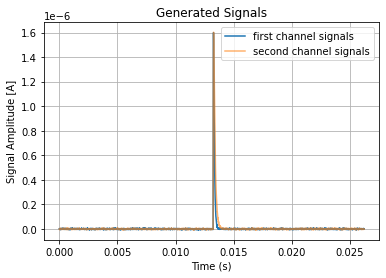

In [4]:
plt.plot(t, signal_1, label='first channel signals')
plt.plot(t, signal_2, alpha=0.6,label='second channel signals')
plt.ylabel("Signal Amplitude [A]")
plt.xlabel("Time (s)")
plt.grid()
plt.legend()
plt.title('Generated Signals')
plt.show()

In [5]:
nchans=2
nbins=len(signal_1)

avgnoise_matrix = np.zeros((100,nchans,nbins)) #calculating csd from 100 traces of noise
avgnoise_matrix[:,0,:] = noise
avgnoise_matrix[:,1,:] = noise2

chans = ['signal1','signal2']
NC = qp.Noise(avgnoise_matrix, fs, chans)
NC.calculate_csd(twosided=True) #csd is returned in A^2/Hz
csd = NC.csd

noise_matrix = np.zeros((nchans,nbins))
noise_matrix[0,:]=noise[0] #just taking one noise trace
noise_matrix[1,:]=noise2[0]

# 2x2

In [6]:
from qetpy.core import OFnxm
from qetpy.core import OFBase

In [7]:
off_diagn_terms = np.zeros_like(template)
templates = np.asarray((template,off_diagn_terms,off_diagn_terms,template2))
signal = np.array([signal_1,signal_2])

# in format 'chan1|chan2' OR 'chan1 | chan2' 
channels = 'signal_1 | signal_2'

template_tags=['template1', 'template2']

pretrigger_samples = nbins//2


In [8]:
ofnxm = OFnxm(template_tags=template_tags, channels=channels, 
              templates=templates, csd=csd,sample_rate=fs, 
              pretrigger_samples=pretrigger_samples)

INFO: Adding template with tag template1 to OF base object. Channel issignal_1
INFO: Adding template with tag template2 to OF base object. Channel issignal_1
INFO: Adding template with tag template1 to OF base object. Channel issignal_2
INFO: Adding template with tag template2 to OF base object. Channel issignal_2
INFO: Adding noise CSD to OF base object


/home/maggie_reed/.local/lib/python3.6/site-packages/qetpy/core/_of_base.py:617: RuntimeWarning: invalid value encountered in true_divide
  template = template/np.max(template)


The noise csd has been calculated: 
[[ 8.48608670e+20+0.j -1.36090506e+20+0.j]
 [-1.36090506e+20+0.j  1.04668983e+21+0.j]]


In [9]:
ofnxm.calc(channels=channels, signal=signal)
amp, t0, chi2 = ofnxm.get_fit_withdelay(channels=channels, signal=signal)
print(f"With Delay Fit: amp = {amp*1e6} uA, t_0 = {t0*1e6} us, chi^2 = {chi2}")


With Delay Fit: amp = [1.59848832 1.5996381 ] uA, t_0 = 128.0 us, chi^2 = 67298.25631306879


# 2x1

In [10]:
templates = np.array([template,off_diagn_terms,off_diagn_terms,off_diagn_terms])
signal = np.array([signal_1,noise2[0]]) #our signal on the second channel is just noise

# in format 'chan1|chan2' OR 'chan1 | chan2' 
channels = 'signal_1 | signal_2'

template_tags=['template1', 'Nosignal']

pretrigger_samples = nbins//2

In [11]:
ofnxm = OFnxm(template_tags=template_tags, channels=channels, 
              templates=templates, csd=csd,sample_rate=fs, 
              pretrigger_samples=pretrigger_samples)

INFO: Adding template with tag template1 to OF base object. Channel issignal_1
INFO: Adding template with tag Nosignal to OF base object. Channel issignal_1
INFO: Adding template with tag template1 to OF base object. Channel issignal_2
INFO: Adding template with tag Nosignal to OF base object. Channel issignal_2
INFO: Adding noise CSD to OF base object


/home/maggie_reed/.local/lib/python3.6/site-packages/qetpy/core/_of_base.py:617: RuntimeWarning: invalid value encountered in true_divide
  template = template/np.max(template)


The noise csd has been calculated: 
[[ 8.48608670e+20+0.j -1.36090506e+20+0.j]
 [-1.36090506e+20+0.j  1.04668983e+21+0.j]]


In [12]:
ofnxm.calc(channels=channels, signal=signal)
amp, t0, chi2 = ofnxm.get_fit_withdelay(channels=channels, signal=signal)
print(f"With Delay Fit: amp = {amp*1e6} uA, t_0 = {t0*1e6} us, chi^2 = {chi2}")

With Delay Fit: amp = [1.59849045 0.        ] uA, t_0 = 128.0 us, chi^2 = 67298.51192665985
